<a href="https://colab.research.google.com/github/auriwan/Recommendation-system/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anime Recommendation System

Auriwan Yasper

Dataset Anime: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=anime.csv

Dataset Rating: https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews

# Pendahuluan

Tema dari analisis ini adalah hiburan dimana hasilnya akan berupa model machine learning yang nanti dapat digunakan untuk dijadikan sebuah sistem rekomendasi anime

# Data Loading

**Import Library**

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

In [2]:
!pip install -q kaggle

In [3]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [5]:
!chmod 600 /content/gdrive/MyDrive/kaggle.json

**Download Dataset Anime**

In [6]:
! KAGGLE_CONFIG_DIR=/content/gdrive/MyDrive kaggle datasets download -d hernan4444/anime-recommendation-database-2020

anime-recommendation-database-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


Download Dataset Rating

In [7]:
! KAGGLE_CONFIG_DIR=/content/gdrive/MyDrive kaggle datasets download -d marlesson/myanimelist-dataset-animes-profiles-reviews

myanimelist-dataset-animes-profiles-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


**Ekstrak Dataset Anime**

In [8]:
file = '/content/anime-recommendation-database-2020.zip'
zip_ref = zipfile.ZipFile(file, 'r')
zip_ref.extractall('/dataset_baru/')
zip_ref.close()

**Extrak dataset Rating**

In [9]:
file = '/content/myanimelist-dataset-animes-profiles-reviews.zip'
zip_ref = zipfile.ZipFile(file, 'r')
zip_ref.extractall('/dataset_baru/')
zip_ref.close()

# **Data Understanding**

dataset ini bersumber dari kaggle dataset dengan 2 sumber dataset, dataset pertama akan digunakan untuk dataset anime dan dataset kedua digunakan untuk dataset rating

**Membuat data frame anime dan rating**

dan kita tampilkan 5 data pertama anime dan rating

In [10]:
df_anime = pd.read_csv('/dataset_baru/anime.csv')
df_rating = pd.read_csv('/dataset_baru/reviews.csv')

df_anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [11]:
df_rating.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


# Exploratory Data Analysis



**Univariate Analysis**

**Deskripsi Variable**

- Variable yang akan digunakan pada anime.csv
  - anime_id = ID dari anime
  - name = Judul Anime
  - genre = Genre dari anime
  - rating = Rating Anime

- Variable pada file users_cleaned.csv
  - user_id = id dari user 
  - anime_id
  - rating = rating yang diberikan user

In [12]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

Selanjutnya memilih column yang diperlukan

In [13]:
df_anime = df_anime[['MAL_ID', 'Genres', 'Name', 'Rating']]

In [14]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192112 entries, 0 to 192111
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uid        192112 non-null  int64 
 1   profile    192112 non-null  object
 2   anime_uid  192112 non-null  int64 
 3   text       192112 non-null  object
 4   score      192112 non-null  int64 
 5   scores     192112 non-null  object
 6   link       192112 non-null  object
dtypes: int64(3), object(4)
memory usage: 10.3+ MB


Memilih column Dataset rating yang diperlukan

In [15]:
df_rating = df_rating[['uid', 'anime_uid', 'score']]

dari data diatas dapat dilihat bahwa skala dari rating yang diberikan adalah 1-10

Selanjutnya kita akan melihat data genre yang terdapat pada dataset anime sebagai berikut

In [16]:
anime_genre = df_anime.copy()
genres=[]
for i in range(len(df_anime.Genres)):
    for x in df_anime.Genres[i].split(', '):
        if x not in genres:
            genres.append(x)
genres

['Action',
 'Adventure',
 'Comedy',
 'Drama',
 'Sci-Fi',
 'Space',
 'Mystery',
 'Shounen',
 'Police',
 'Supernatural',
 'Magic',
 'Fantasy',
 'Sports',
 'Josei',
 'Romance',
 'Slice of Life',
 'Cars',
 'Seinen',
 'Horror',
 'Psychological',
 'Thriller',
 'Super Power',
 'Martial Arts',
 'School',
 'Ecchi',
 'Vampire',
 'Military',
 'Historical',
 'Dementia',
 'Mecha',
 'Demons',
 'Samurai',
 'Game',
 'Shoujo',
 'Harem',
 'Music',
 'Shoujo Ai',
 'Shounen Ai',
 'Kids',
 'Hentai',
 'Parody',
 'Yuri',
 'Yaoi',
 'Unknown']

In [17]:
print("Genres amount : {}".format(len(genres)))

Genres amount : 44


Jadi pada dataset terdapat 44 genre yang tersedia, dan kita akan membuat visualisasinya sebagai berikut

Lalu kita akan membuat genre menjadi satu kolom dalam dataset

In [18]:
for x in genres:
    anime_genre[x] = 0

for i in range(len(df_anime.Genres)):
    for x in df_anime.Genres[i].split(', '):
        anime_genre[x][i]=1

anime_genre.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MAL_ID,Genres,Name,Rating,Action,Adventure,Comedy,Drama,Sci-Fi,Space,...,Harem,Music,Shoujo Ai,Shounen Ai,Kids,Hentai,Parody,Yuri,Yaoi,Unknown
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,R - 17+ (violence & profanity),1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop: Tengoku no Tobira,R - 17+ (violence & profanity),1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,PG-13 - Teens 13 or older,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,PG-13 - Teens 13 or older,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,"Adventure, Fantasy, Shounen, Supernatural",Bouken Ou Beet,PG - Children,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Selanjutnya kita akan menampilkan data sebaran genre anime

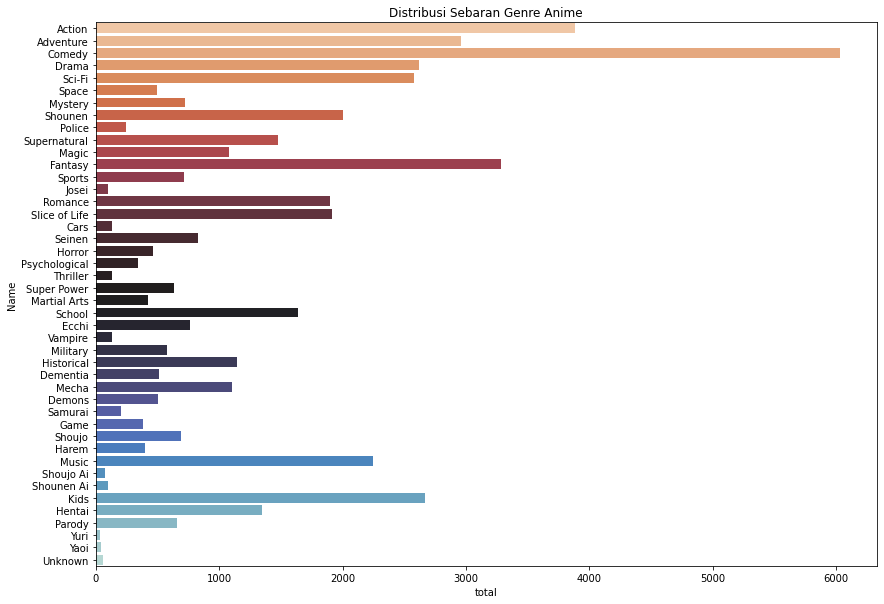

In [19]:
data = anime_genre.iloc[:,4:].sum().reset_index()
data.columns = ['Name','total']

plt.figure(figsize=(14,10))
sns.barplot(y='Name', x='total', data=data, palette='icefire_r')
plt.title('Distribusi Sebaran Genre Anime')
plt.show()

# Data Preparation

**Mengecek Missing Value**

In [20]:
df_anime.isnull().sum()

MAL_ID    0
Genres    0
Name      0
Rating    0
dtype: int64

tidak ada data missing value pada datase

In [21]:
df_rating.isnull().sum()

uid          0
anime_uid    0
score        0
dtype: int64

untuk dataset rating tidak terdapat missing value

In [22]:
df_anime.isnull().sum()

MAL_ID    0
Genres    0
Name      0
Rating    0
dtype: int64

**Mengecek data Duplikat**

In [23]:
df_anime.duplicated().sum()

0

In [24]:
df_rating.duplicated().sum()

61593

pada data rating terdapat 61593 data duplikat dan data ini akan kita hapus saja

In [25]:
df_rating.drop_duplicates(subset=['uid','anime_uid'], keep='first', inplace=True)
df_rating.duplicated().sum()

0

# Model Development



# **Content-Based-Filtering**



pertama kita akan mempersiapkan data untuk cosine similarity dengan TfidfVectorizer, lalu mendapatkan fiur penting pada data genre 

In [26]:
tfid = TfidfVectorizer(stop_words='english')
tfid.fit(df_anime['Genres'])
tfid.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'ai',
 'arts',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'fi',
 'game',
 'harem',
 'hentai',
 'historical',
 'horror',
 'josei',
 'kids',
 'life',
 'magic',
 'martial',
 'mecha',
 'military',
 'music',
 'mystery',
 'parody',
 'police',
 'power',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci',
 'seinen',
 'shoujo',
 'shounen',
 'slice',
 'space',
 'sports',
 'super',
 'supernatural',
 'thriller',
 'unknown',
 'vampire',
 'yaoi',
 'yuri']

selanjutnya kita akan melakukan fitting dan mengubah kedalam bentuk matriks

In [27]:
tfidf_matrix = tfid.fit_transform(df_anime['Genres']) 
tfidf_matrix.shape

(17562, 47)

angka diatas adalah ukuran dari matriks kita, dan untuk melihat vektor tf-idf dalam bentuk matriks kita jalankan kode berikut

In [28]:
cosine_sim = cosine_similarity(tfidf_matrix)
print(cosine_sim.shape)
cosine_sim

(17562, 17562)


array([[1.        , 0.78149159, 0.74413675, ..., 0.        , 0.26144077,
        0.21333391],
       [0.78149159, 1.        , 0.51816708, ..., 0.18292702, 0.        ,
        0.2048185 ],
       [0.74413675, 0.51816708, 1.        , ..., 0.        , 0.28731405,
        0.23444634],
       ...,
       [0.        , 0.18292702, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.26144077, 0.        , 0.28731405, ..., 0.        , 1.        ,
        0.        ],
       [0.21333391, 0.2048185 , 0.23444634, ..., 0.        , 0.        ,
        1.        ]])

dari matriks tf-idf diatas kita lihat bagaimana similarity dari dataset anime yang kita miliki

In [29]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_anime['Name'],
                             columns=df_anime['Name'])
print('Size dataframe:', cosine_sim_df.shape)
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Size dataframe: (17562, 17562)


Name,Stringendo+Accelerando Ultimatum Sera,Nanocore 2nd Season,Can Ci Pin,Shin Ace wo Nerae!,Yurumates wa?,Tesapuru dayo! Schedule no Au Hito dake Shuugou!,Touhai Densetsu Akagi: Yami ni Maiorita Tensai,91 Daze,Tensei shitara Slime Datta Ken: Kanwa - Veldora Nikki,Danna ga Nani wo Itteiru ka Wakaranai Ken
Name,,,,,,,,,,
Feng Ji Yun Nu,0.0,0.182727,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
"Kirai, Demo, Suki",0.0,0.686461,0.803379,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Muku no Ki no Hanashi,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Gakkou no Kaidan Recaps,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Pussy,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Saibi,0.0,0.000000,0.000000,0.127323,0.000000,0.000000,0.72355,0.000000,0.000000,0.000000
Ane to Boin,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Super Kuma-san,0.0,0.000000,0.000000,0.000000,0.196742,0.611657,0.00000,0.296675,0.734861,0.175888
Bobobo-bo Bo-bobo,0.0,0.565969,0.662365,0.000000,0.106878,0.332275,0.00000,0.161165,0.489386,0.095549


# Model

selanjutnya kita akan membuat fungsi untuk merekomendasikan 10 anime berdasarkan similaritynya 

In [30]:
def AnimeRecommendations(anime_name, similarity_data=cosine_sim_df, 
                         items=df_anime[['MAL_ID','Name','Genres']], k=10):
  
    ''' Mengambil data menggunakan argpartition untuk partisi secara tidak langsung,
    sepanjang sumbu yang diberikan, kemudian dataframe diubah menjadi numpy Range 
    dengan parameter sebagai berikut (start, stop, step) '''
    index = similarity_data.loc[:, anime_name].to_numpy().argpartition(
        range(-1, -k, -1)
    )
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(anime_name, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

selanjutnya kita akan menyalin data tersendiri untuk conten base filtering dengan nama variabel df_anime_cbf

In [31]:
df_anime_cbf = df_anime.copy()

# Collaborative Filtering

pertama kita perlu menggabungkan data anime dan rating terlebih dahulu, dan menyamakan variabel yang akan kita gabungkan

In [32]:
df_anime.columns = ['anime_id', 'genre', 'name', 'Rating']
df_anime.head()

,anime_id,genre,name,Rating
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,R - 17+ (violence & profanity)
1,5,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop: Tengoku no Tobira,R - 17+ (violence & profanity)
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,PG-13 - Teens 13 or older
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,PG-13 - Teens 13 or older
4,8,"Adventure, Fantasy, Shounen, Supernatural",Bouken Ou Beet,PG - Children


In [33]:
df_rating.columns = ['user_id', 'anime_id', 'rating']
df_rating.head()

,user_id,anime_id,rating
0,255938,34096,8
1,259117,34599,10
2,253664,28891,7
3,8254,2904,9
4,291149,4181,10


In [34]:
rating_anime = pd.merge(df_rating, df_anime, on='anime_id', how='inner')
rating_anime.drop(['Rating'],axis=1, inplace=True)
rating_anime.head()

,user_id,anime_id,rating,genre,name
0,255938,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
1,249891,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
2,313501,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
3,317041,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
4,245369,34096,7,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.


# Visualisasi sebaran 10 anime dengan rating tertinggi

In [35]:
rating_anime_count = rating_anime.groupby('name')['rating'].count()
rating_anime_count = pd.DataFrame(rating_anime_count).reset_index().rename(columns={'rating':'total_rating'})
rating_anime_count.head()

,name,total_rating
0,"""0""",3
1,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",2
2,"""Bungaku Shoujo"" Memoire",3
3,"""Bungaku Shoujo"" Movie",28
4,"""Calpis"" Hakkou Monogatari",2


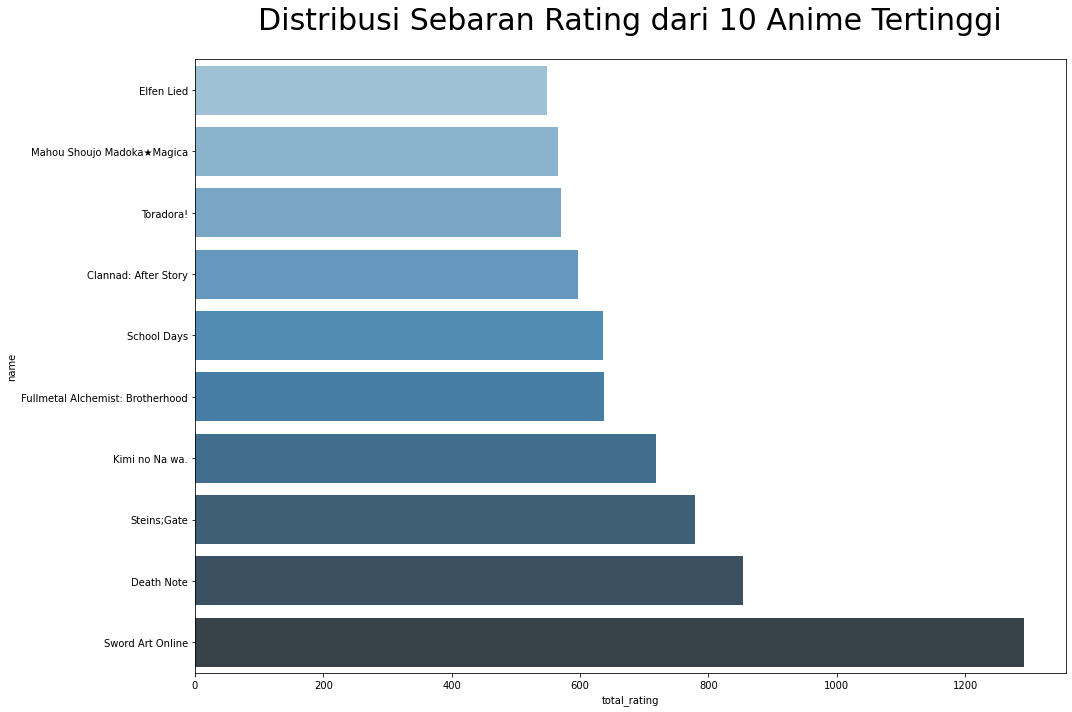

In [36]:
data = rating_anime_count.sort_values(by ='total_rating')

plt.figure(figsize=(15,10))
sns.barplot(data=data.iloc[-10:,:], 
            y='name', x='total_rating',
            palette="Blues_d")
plt.title('Distribusi Sebaran Rating dari 10 Anime Tertinggi', pad=30, fontsize=30)
plt.tight_layout()
plt.show()

dari data diatas bisa kita lihat anime dengan rating tertinggi dipegang oleh Sword art online

selanjutnya kita akan mengambil data rating ini sebagai data utama kita dengan nama merge_df

In [37]:
merge_df = rating_anime
merge_df.head()

,user_id,anime_id,rating,genre,name
0,255938,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
1,249891,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
2,313501,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
3,317041,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.
4,245369,34096,7,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.


# Data preparation

pada tahap ini kita akan mengubah unique user_id dan anime_id menjadi list, lalu melakukan encoding user_id dan encoding anime_id, dan encoding angka ke user_id dan anime

In [38]:
user_id = merge_df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}

In [39]:
anime_id = merge_df['anime_id'].unique().tolist()
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_id)}
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_id)}

Selanjutnya kita melakukan mapping data user id dan anime id

In [40]:
merge_df['user'] = merge_df['user_id'].map(user_to_user_encoded)
merge_df['anime'] = merge_df['anime_id'].map(anime_to_anime_encoded)
merge_df.head()

,user_id,anime_id,rating,genre,name,user,anime
0,255938,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.,0,0
1,249891,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.,1,0
2,313501,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.,2,0
3,317041,34096,8,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.,3,0
4,245369,34096,7,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama.,4,0


selanjutnya kita akan mendapatkan jumlah user dan anime, lalu merubah tipe data variabel rating menjadi float, lalu melihat nilai maksimum dan nilai minimum pada rating

In [41]:
num_users = len(user_to_user_encoded)
num_anime = len(anime_encoded_to_anime)
merge_df['rating'] = merge_df['rating'].values.astype(np.float32)
min_rating = min(merge_df['rating'])
max_rating = max(merge_df['rating'])

print(f'Number of User: {num_users}')
print(f'Number of anime: {num_anime}')
print(f'Min rating: {min_rating}')
print(f'Max rating: {max_rating}')

Number of User: 130488
Number of anime: 8107
Min rating: 0.0
Max rating: 11.0


# Pembagian dataset training dan test

sebelum kita masuk pembagian dataset kita akan melakukan acak dataset

In [42]:
df = merge_df.sample(frac=1, random_state=30)
df.head()

,user_id,anime_id,rating,genre,name,user,anime
92072,301984,36432,7.0,"Action, Sci-Fi, Super Power, Magic",Toaru Majutsu no Index III,92072,4660
105849,200877,25283,7.0,"Action, Drama, Fantasy, Magic, School",Kuusen Madoushi Kouhosei no Kyoukan,105849,6013
16033,195390,889,9.0,"Action, Seinen",Black Lagoon,16033,325
28268,238424,31240,9.0,"Psychological, Drama, Thriller, Fantasy",Re:Zero kara Hajimeru Isekai Seikatsu,28268,529
50891,20277,1562,8.0,"Comedy, Shoujo",Yamato Nadeshiko Shichihenge♥,50891,817


Tahap selanjutnya kita akan membuat sebuat variabel x yang akan menampung data user dan anime, dan variabel y untuk menampung data rating. selanjutnya kita akan membagi dataset sebanyak 80% data train dan 20% data test

In [43]:
x = merge_df[['user', 'anime']].values
y = merge_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * merge_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# Melatih model

pertama kita akan membuat class dan fungsi inisialisasi

In [44]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x)

**Compile Model dan membuat callback**

In [45]:
model = RecommenderNet(num_users, num_anime, 50) # inisialisasi model

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()]]
)
callbacks = EarlyStopping(
    min_delta=0.0001,
    patience=7,
    restore_best_weights=True,
)

In [46]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[callbacks]
)

Epoch 1/100
13049/13049 [==============================] - 153s 11ms/step - loss: 0.6442 - mean_absolute_error: 0.1978 - root_mean_squared_error: 0.2290 - val_loss: 0.6938 - val_mean_absolute_error: 0.2041 - val_root_mean_squared_error: 0.2360
Epoch 2/100
13049/13049 [==============================] - 149s 11ms/step - loss: 0.6085 - mean_absolute_error: 0.1528 - root_mean_squared_error: 0.1892 - val_loss: 0.6938 - val_mean_absolute_error: 0.2041 - val_root_mean_squared_error: 0.2360
Epoch 3/100
13049/13049 [==============================] - 148s 11ms/step - loss: 0.5986 - mean_absolute_error: 0.1378 - root_mean_squared_error: 0.1773 - val_loss: 0.6939 - val_mean_absolute_error: 0.2041 - val_root_mean_squared_error: 0.2360
Epoch 4/100
13049/13049 [==============================] - 149s 11ms/step - loss: 0.5926 - mean_absolute_error: 0.1287 - root_mean_squared_error: 0.1698 - val_loss: 0.6939 - val_mean_absolute_error: 0.2041 - val_root_mean_squared_error: 0.2360
Epoch 5/100
13049/13049 

Selanjutnya kita akan menguji dengan salah satu sampel user dan menguji rekomendasi dengan model yang sudah kita rancang

In [47]:
user_id = merge_df.user_id.sample(1).iloc[0]
anime_watched_by_user = merge_df[merge_df.user_id == user_id]
 
anime_not_watched = df_anime[~df_anime['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id'] 
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

 
anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

In [48]:
ratings = model.predict(user_anime_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('====' * 10)
print('movie with high ratings from user')
print('----' * 8)
 
top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)
 
anime_df_rows = df_anime[df_anime['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.name)
 
print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)
 
recommended_anime = df_anime[df_anime['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name)

Showing recommendations for users: 61977
movie with high ratings from user
--------------------------------
Mobile Suit Gundam SEED Destiny
--------------------------------
Top 10 anime recommendation
--------------------------------
Cowboy Bebop
Fullmetal Alchemist
Death Note
Tengen Toppa Gurren Lagann
Clannad: After Story
Toradora!
Fullmetal Alchemist: Brotherhood
Steins;Gate
Mahou Shoujo Madoka★Magica
Kimi no Na wa.


# Evaluation

Pada tahap ini penulis menggunakan dua teknik yaitu :

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

Dan untuk Sistem Rekomendasi Content Based Filtering Saya menggunakan Precision

# Plot Grafik MAE

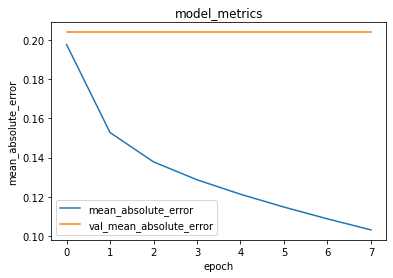

In [49]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.show()

# Plot Grafik RMSE

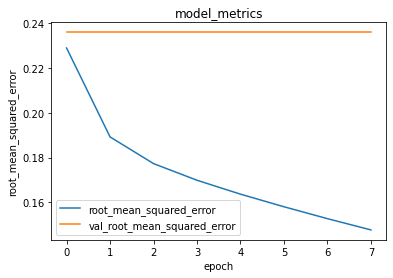

In [50]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'])
plt.show()

In [51]:
df_anime.head()

,anime_id,genre,name,Rating
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,R - 17+ (violence & profanity)
1,5,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop: Tengoku no Tobira,R - 17+ (violence & profanity)
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,PG-13 - Teens 13 or older
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,PG-13 - Teens 13 or older
4,8,"Adventure, Fantasy, Shounen, Supernatural",Bouken Ou Beet,PG - Children


# Precision

In [54]:
find_name = df_anime_cbf[df_anime_cbf['Name'] == 'Cowboy Bebop']
find_name

,MAL_ID,Genres,Name,Rating
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,R - 17+ (violence & profanity)


In [55]:
anime_name = 'Cowboy Bebop'
anime_recomend = AnimeRecommendations(anime_name)
anime_recomend

,Name,MAL_ID,Genres
0,Cowboy Bebop: Yose Atsume Blues,4037,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,Ginga Tetsudou Monogatari,1490,"Action, Adventure, Drama, Sci-Fi, Space"
2,Uchuu Kaizoku Captain Herlock: Arcadia-gou no ...,2470,"Action, Sci-Fi, Adventure, Space, Drama"
3,Waga Seishun no Arcadia: Mugen Kidou SSX,2203,"Action, Adventure, Drama, Sci-Fi, Space"
4,Waga Seishun no Arcadia,2202,"Action, Adventure, Drama, Sci-Fi, Space"
5,Odin: Koushi Hansen Starlight,1287,"Action, Sci-Fi, Adventure, Space, Drama"
6,Ginga Tetsudou Monogatari: Eien e no Bunkiten,2717,"Action, Adventure, Space, Drama, Sci-Fi"
7,Seihou Bukyou Outlaw Star,400,"Action, Sci-Fi, Adventure, Space, Comedy"
8,Ginga Tetsudou 999 (ONA),28733,"Sci-Fi, Adventure, Space, Drama"
9,Sayonara Ginga Tetsudou 999: Andromeda Shuucha...,1302,"Sci-Fi, Adventure, Space, Drama"
